# YOLO Pretraining with IMAGENET-VID

## Imports

In [ ]:
%pip install huggingface_hub ultralytics torchinfo pygwalker comet_ml xmltodict

In [1]:
import os
import shutil
from os import path

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets, utils, transforms
from torchinfo import summary
from ultralytics import YOLO

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pygwalker as pyg

In [2]:
import comet_ml
from comet_ml.integration.pytorch import log_model

# Set model name
MODEL_NAME = "yolo11m"

# Attatch logger to the current project
comet_ml.login()
exp = comet_ml.start(project_name=MODEL_NAME)
print(exp.url)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/b-re-w/yolo11m/5d86567977a04496949dcec6467559ce



https://www.comet.com/b-re-w/yolo11m/5d86567977a04496949dcec6467559ce


In [3]:
import psutil
import time


def register_logger_hooks(model, optimizer, total_batches):
    start_time = time.time()
    
    def update_time():
        nonlocal start_time
        start_time = time.time()
    
    def log_metrics_per_batch(epoch, batch_idx, **log_data):
        # Learning Rate (LR)
        for i, param_group in enumerate(optimizer.param_groups):
            log_data[f"learning_rate/group_{i}"] = param_group['lr']

        # Gradient Norm
        total_norm = torch.norm(torch.stack([torch.norm(p.grad) for p in model.parameters() if p.grad is not None]))
        log_data["gradient_norm"] = total_norm.item()

        # Mean/Std of Weights
        for name, param in model.named_parameters():
            log_data[f"weights/{name}_mean"] = param.data.mean().item()
            log_data[f"weights/{name}_std"] = param.data.std().item()

        # Activations
        def activation_hook(module, input, output):
            log_data[f"activations/{module.__class__.__name__}_mean"] = output.mean().item()
            log_data[f"activations/{module.__class__.__name__}_std"] = output.std().item()

        for layer in model.children():
            layer.register_forward_hook(activation_hook)

        # Memory Usage
        if torch.cuda.is_available():
            for i in range(torch.cuda.device_count()):
                log_data[f"gpu_{i}/memory_allocated"] = torch.cuda.memory_allocated(i) / 1024**2  # MB
                log_data[f"gpu_{i}/memory_reserved"] = torch.cuda.memory_reserved(i) / 1024**2
        log_data["cpu_usage"] = psutil.cpu_percent()

        # Time Elapsed
        log_data["batch_time"] = time.time() - start_time

        # Send to Comet
        exp.log_metrics(log_data, step=batch_idx + epoch * total_batches)
    
    return update_time, log_metrics_per_batch

### Check GPU Availability

In [4]:
!nvidia-smi

Wed Mar 12 10:41:19 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   40C    P0    34W / 250W |   6077MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [5]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 4
ADDITIONAL_GPU = 1

if torch.cuda.is_available():
    if ADDITIONAL_GPU:
        torch.cuda.set_device(DEVICE_NUM)
        device = torch.device("cuda")
    else:
        device = torch.device(f"cuda:{DEVICE_NUM}")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1

print(f"INFO: Using device - {device}" + (f":{DEVICE_NUM}" if ADDITIONAL_GPU else ""))

INFO: Using device - cuda:4


## Define Dataset
ImageNet-VID

In [6]:
from typing import Callable, Optional
from dataclasses import dataclass
from pathlib import Path
import huggingface_hub
import xmltodict
import sys


class ImageNetVIDDataset(datasets.ImageFolder):
    """
    ImageNet-VID dataset for Object Detection and Tracking.
    Only works in Linux.
    
    :ref: https://huggingface.co/datasets/guanxiongsun/imagenetvid
    """

    download_method = huggingface_hub.snapshot_download
    dataset_name = "ILSVRC2015_VID"
    dataset_id = "guanxiongsun/imagenetvid"
    obj_classes = [
        "n02691156", "n02419796", "n02131653", "n02834778", "n01503061",
        "n02924116", "n02958343", "n02402425", "n02084071", "n02121808",
        "n02503517", "n02118333", "n02510455", "n02342885", "n02374451",
        "n02129165", "n01674464", "n02484322", "n03790512", "n02324045",
        "n02509815", "n02411705", "n01726692", "n02355227", "n02129604",
        "n04468005", "n01662784", "n04530566", "n02062744", "n02391049"
    ]
    obj_class_namees = [
        "airplane", "antelope", "bear", "bicycle", "bird", "bus", "car", "cattle",
        "dog", "domestic cat", "elephant", "fox", "giant panda", "hamster", "horse",
        "lion", "lizard", "monkey", "motorcycle", "rabbit", "red panda",
        "sheep", "snake", "squirrel", "tiger", "train", "turtle",
        "watercraft", "whale", "zebra"
    ]

    def __init__(
        self,
        root: str,
        force_download: bool = True,
        train: bool = True,
        valid: bool = False,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
        ):
        self.root = path.join(root, self.dataset_name)
        self.download(self.root, force=force_download)
        self.default_target_transform = transforms.Lambda(lambda x: self.query_annotation(x))
        target_transform = transforms.Compose([
            self.default_target_transform, target_transform
        ]) if target_transform is not None else self.default_target_transform

        if train:
            self.root = path.join(self.root, "val") if valid else path.join(self.root, "train")
        else:
            self.root = path.join(self.root, "test")

        super().__init__(root=self.root, transform=transform, target_transform=target_transform)
        self.cached_annotations = [None] * len(self.samples)
        self.samples = [(data[0], (data[1], idx)) for idx, data in enumerate(self.samples)]

    def query_annotation(self, img_info: int):
        img_index = img_info[1]
        cache = self.cached_annotations[img_index]
        if cache is None:
            file_path = self.samples[img_index][0].replace(".jpeg", ".xml").replace(".JPEG", ".xml")
            
            with open(file_path, 'r', encoding='utf-8') as f:
                xml_content = f.read()
                cache = self.cached_annotations[img_index] = xmltodict.parse(xml_content)['annotation']
            
            try:
                objects = cache['object'] if isinstance(cache['object'], list) else [cache['object']]  # Make sure it is a list
                del cache['object']
                cache['labels'] = [self.obj_classes.index(obj['name']) for obj in objects]
                cache['boxes'] = [
                    [float(obj['bndbox'][key]) for key in ['xmin', 'ymin', 'xmax', 'ymax']] for obj in objects
                ]
            except KeyError:
                cache['labels'], cache['boxes'] = [], []
        return cache

    @staticmethod
    def label_transform(img_info: dict, normalize: bool = False):
        bboxes_info, labels_info = img_info['boxes'], img_info['labels']
        if normalize:
            height, width = float(img_info['size']['height']), float(img_info['size']['width'])
            bboxes_info = [[
                bbox_info[0] / width, bbox_info[1] / height,  # xmin, ymin
                bbox_info[2] / width, bbox_info[3] / height  # xmax, ymax
            ] for bbox_info in bboxes_info]
        return dict(boxes=torch.tensor(bboxes_info), labels=torch.tensor(labels_info))

    @classmethod
    def download(cls, root: str, force: bool = False):
        root = Path(root)
        
        # Clean up the existing dataset if force is flagged
        if force:
            print(f"INFO: Cleaning up the existing dataset at {root} (Force-download is flagged)")
            for item in os.listdir(root):
                item_path = root / item
                if path.isfile(item_path):
                    os.remove(item_path)
                else:
                    shutil.rmtree(item_path)
            print("INFO: Dataset cleaned successfully.")

        # Do download if the dataset does not exist
        print(f"INFO: Downloading '{cls.dataset_id} from huggingface to {root}...")
        dnlod = lambda: cls.download_method(
            repo_id=cls.dataset_id,
            repo_type="dataset",
            local_dir=root,
            ignore_patterns=["*.git*", "*.md", "*ILSVRC2017*", "annotations.tar.gz"],
        )
        if force or not (
            path.exists(root) and any(p for p in Path(root).iterdir() if not p.name.startswith('.'))
        ):  # Check if dataset files already exist in the directory
            dnlod()
            print("INFO: Dataset downloaded successfully.")
        else:
            dnlod()  # make sure the dataset is up-to-date
            print("INFO: Dataset files found in the root directory. Skipping download.")
        
        # Combine split achives
        dataset_archive, annotation_archive = root / f"{cls.dataset_name}.tar.gz", root / "annotations.tar.gz"
        if not path.exists(dataset_archive):
            print("INFO: Combining seperated archives...")
            result = os.system(f"cat {dataset_archive}.a* | dd status=progress of={dataset_archive}")
            #result = os.system(f"cat {dataset_archive}.a* | pv -s $(du -bc {dataset_archive}.a* | tail -1 | cut -f1) > {dataset_archive}")
            if result != 0:
                raise Exception("Failed to combine split archives. Please make sure that you are running on a Linux system.")
            print("INFO: Split archives combined successfully.")
        else:
            print("INFO: Combined archives found in the root directory. Skipping combination.")

        # Extract the dataset
        if path.isdir(root / "train") and any(p for p in Path(root / "train").iterdir() if not p.name.startswith('.')) \
            and path.isdir(root / "val") and any(p for p in Path(root / "val").iterdir() if not p.name.startswith('.')):
            print("INFO: Dataset is already extracted")
        else:
            print("INFO: Extracting the dataset...", flush=True)
            if os.system(f"dd if={dataset_archive} bs=4M status=progress | tar -I pigz -x -C {root}") \
                or os.system(f"dd if={annotation_archive} bs=4M status=progress | tar -I pigz -x -C {root}") \
            :
                #os.system(f"pv {dataset_archive} | tar -I pigz -x -C {root}")
                print("\nERROR: Cannot find pigz in the system, using default tar command instead", file=sys.stderr, flush=True)
                if os.system(f"dd if={dataset_archive} bs=4M status=progress | tar -x -C {root}") \
                    or os.system(f"dd if={annotation_archive} bs=4M status=progress | tar -x -C {root}") \
                :
                    #os.system(f"pv {dataset_archive} | tar -x -C {root}")
                    raise Exception(f"Failed to extract {dataset_archive}")
            # ----
            # Move files to the correct directories
            temp_dir = root / cls.dataset_name.replace("_VID", "")
            # ---- metadata
            #os.system(f"mv {temp_dir}/ImageSets/VID/* {root}")
            # ---- datas
            for subdir in os.listdir(f"{temp_dir}/Data/VID/train"):  # flatten the train data directory
                annt = temp_dir / "Annotations" / "VID" / "train"
                dt = temp_dir / "Data" / "VID" / "train"
                os.system(f"mv {annt}/{subdir}/* {annt}/")
                os.system(f"mv {dt}/{subdir}/* {dt}/")
                os.system(f"rmdir {annt}/{subdir}")
                os.system(f"rmdir {dt}/{subdir}")
            os.system(f"mv {temp_dir}/Data/VID/* {root}")  # copy images
            for data_type in ["train", "val"]:
                for subdir in os.listdir(f"{root}/{data_type}"):  # copy lables
                    os.system(f"mv {temp_dir}/Annotations/VID/{data_type}/{subdir}/* {root}/{data_type}/{subdir}")
            os.system(f"rm -r {temp_dir}")
            # ---- json files
            os.system(f"mv {root}/annotations/{cls.annotation_files.train} {root}/train/{cls.annotation_files.train}")
            os.system(f"mv {root}/annotations/{cls.annotation_files.val} {root}/val/{cls.annotation_files.val}")
            os.system(f"rm -r {root}/annotations/")

            print("INFO: Dataset is extracted successfully")

    @property
    def df(self) -> pd.DataFrame:
        return pd.DataFrame(dict(path=[d[0] for d in self.samples], label=[self.classes[lb] for lb in self.targets]))

    def output_sampling(self, img_norm: dict, idx: int | None = None, figsize=(7, 5), imgsize=(224, 224)):
        # Get random index if not provided
        if idx is None:
            idx = np.random.randint(len(self))
            if idx == 0:
                idx = 1
        
        # Get frame pair
        (prev_img, prev_gt), (curr_img, curr_gt) = self[idx-1], self[idx]
        
        # Convert tensors to numpy arrays and denormalize
        def denormalize(img_tensor):
            # Move channels to last dimension
            img = img_tensor.permute(1, 2, 0).numpy()
            # Denormalize
            img = img * np.array(img_norm['std']) + np.array(img_norm['mean'])
            # Clip values to valid range
            img = np.clip(img, 0, 1)
            return img
        
        prev_img = denormalize(prev_img)
        curr_img = denormalize(curr_img)
        
        def draw_bbox(ax, bbox, color='red'):
            """Helper function to draw bounding box"""
            xmin, ymin, xmax, ymax = bbox.numpy()
            xmin *= imgsize[0]  # xmin
            ymin *= imgsize[1]  # ymin
            xmax *= imgsize[0]  # xmax
            ymax *= imgsize[1]  # ymax
            ax.plot([xmin, xmax], [ymin, ymin], color=color, linewidth=2)
            ax.plot([xmin, xmin], [ymin, ymax], color=color, linewidth=2)
            ax.plot([xmax, xmax], [ymin, ymax], color=color, linewidth=2)
            ax.plot([xmin, xmax], [ymax, ymax], color=color, linewidth=2)

        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Plot previous frame
        ax1.imshow(prev_img)
        for bbox in prev_gt['boxes']:
            draw_bbox(ax1, bbox)
        ax1.set_title('Previous Frame')
        ax1.axis('off')
        
        # Plot current frame
        ax2.imshow(curr_img)
        for bbox in curr_gt['boxes']:
            draw_bbox(ax2, bbox)
        ax2.set_title('Current Frame')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return idx

In [7]:
# Define image size for resizing
IMG_SIZE = 640

# Define image normalization parameters (ImageNet style)
IMG_NORM = dict(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
LABEL_NORM = True

# Create transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
    transforms.ToTensor(),
    transforms.Normalize(**IMG_NORM)
])
label_transform = lambda norm: transforms.Lambda(
    lambda x: ImageNetVIDDataset.label_transform(x, normalize=norm)
)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(), 
    transforms.Normalize(**IMG_NORM)
])

In [8]:
DATA_ROOT = path.join(".", "data")

train_dataset = ImageNetVIDDataset(
    root=DATA_ROOT, force_download=False, train=True,
    transform=train_transform, target_transform=label_transform(norm=True)
)
valid_dataset = ImageNetVIDDataset(
    root=DATA_ROOT, force_download=False, valid=True,
    transform=train_transform, target_transform=label_transform(norm=True)
)
test_dataset = ImageNetVIDDataset(
    root=DATA_ROOT, force_download=False, train=False,
    transform=test_transform
)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

INFO: Downloading 'guanxiongsun/imagenetvid from huggingface to data/ILSVRC2015_VID...


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

INFO: Dataset files found in the root directory. Skipping download.
INFO: Combined archives found in the root directory. Skipping combination.
INFO: Dataset is already extracted
INFO: Downloading 'guanxiongsun/imagenetvid from huggingface to data/ILSVRC2015_VID...


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

INFO: Dataset files found in the root directory. Skipping download.
INFO: Combined archives found in the root directory. Skipping combination.
INFO: Dataset is already extracted
INFO: Downloading 'guanxiongsun/imagenetvid from huggingface to data/ILSVRC2015_VID...


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

INFO: Dataset files found in the root directory. Skipping download.
INFO: Combined archives found in the root directory. Skipping combination.
INFO: Dataset is already extracted
INFO: Dataset loaded successfully. Number of samples - Train(1122397), Valid(176126), Test(315176)


In [9]:
# Train Dataset Distribution
pyg.walk(train_dataset.df)

Box(children=(HTML(value='\n<div id="ifr-pyg-00063022da357c7egcZPlS1QRfG2vKpn" style="height: auto">\n    <hea…

In [10]:
train_dataset[1]

(tensor([[[-0.7650, -0.7137, -0.6281,  ...,  0.4337,  0.4337,  0.4337],
          [-0.7650, -0.7137, -0.6452,  ...,  0.4337,  0.4337,  0.4508],
          [-0.7822, -0.7479, -0.6794,  ...,  0.4508,  0.4679,  0.4679],
          ...,
          [ 0.0056,  0.0741,  0.1254,  ...,  1.2899,  1.2385,  1.2214],
          [ 0.0056,  0.0912,  0.1426,  ...,  1.3070,  1.2899,  1.2728],
          [ 0.0056,  0.0912,  0.1426,  ...,  1.3070,  1.3242,  1.3242]],
 
         [[-0.6176, -0.5476, -0.4601,  ...,  0.7304,  0.7304,  0.7479],
          [-0.6176, -0.5476, -0.4601,  ...,  0.7479,  0.7479,  0.7479],
          [-0.6352, -0.5826, -0.5126,  ...,  0.7479,  0.7654,  0.7654],
          ...,
          [ 0.4678,  0.5203,  0.5728,  ...,  1.5182,  1.4657,  1.4482],
          [ 0.4853,  0.5203,  0.5553,  ...,  1.5357,  1.5182,  1.5007],
          [ 0.4853,  0.5203,  0.5553,  ...,  1.5357,  1.5532,  1.5532]],
 
         [[-0.3230, -0.2532, -0.1835,  ...,  0.7054,  0.7054,  0.7054],
          [-0.3230, -0.2532,

In [11]:
train_dataset.samples[100000]

('./data/ILSVRC2015_VID/train/ILSVRC2015_train_00054001/000028.JPEG',
 (486, 100000))

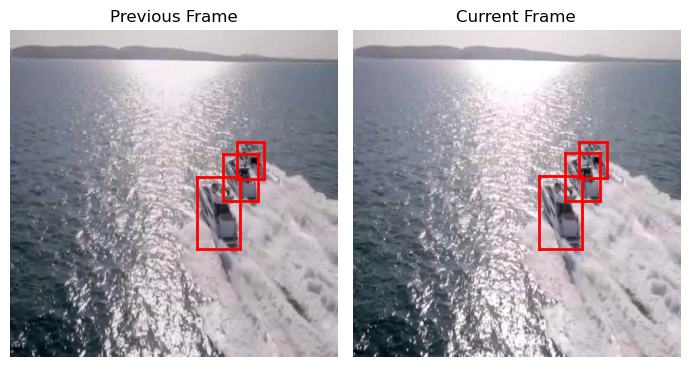

Visualized pair index: 489477


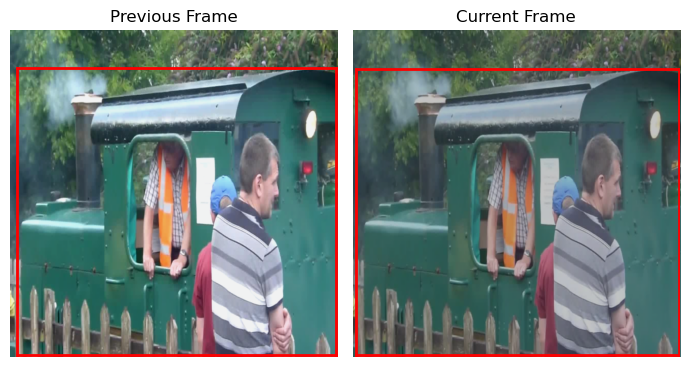

Visualized pair index: 856453


In [12]:
for _ in range(2):
    selected_idx = train_dataset.output_sampling(img_norm=IMG_NORM, imgsize=(IMG_SIZE, IMG_SIZE))
    print(f"Visualized pair index: {selected_idx}")

## DataLoader

In [13]:
# Set Batch Size
BATCH_SIZE = 512, 512, 1

In [14]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE[0], shuffle=True, num_workers=cpu_cores)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE[1], shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE[2], shuffle=False, num_workers=cpu_cores)

INFO: Number of CPU cores - 48


## Load Model

In [15]:
#model = YOLO("yolo11m.yaml").model
model = YOLO("./pretrained/yolo11m.pt").model

if ADDITIONAL_GPU:
    model = nn.DataParallel(model, device_ids=list(range(DEVICE_NUM, DEVICE_NUM+ADDITIONAL_GPU+1)))
model.to(device)

DataParallel(
  (module): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=Tru

In [16]:
summary(model.module, input_size=(1, 3, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                                       Output Shape              Param #
DetectionModel                                               [1, 84, 8400]             --
├─Sequential: 1-1                                            --                        --
│    └─Conv: 2-1                                             [1, 64, 320, 320]         --
│    │    └─Conv2d: 3-1                                      [1, 64, 320, 320]         (1,728)
│    │    └─BatchNorm2d: 3-2                                 [1, 64, 320, 320]         (128)
│    └─Detect: 2-174                                         --                        (recursive)
│    │    └─ModuleList: 3-197                                --                        (recursive)
│    └─Conv: 2-3                                             [1, 128, 160, 160]        --
│    │    └─Conv2d: 3-4                                      [1, 128, 160, 160]        (73,728)
│    │    └─BatchNorm2d: 3-5                                 [1

## Train

In [17]:
# Set Epoch Count & Learning Rate
EPOCHS = 100
MODEL_BACKUP = 5
LEARNING_RATE = 1e-3, 1e-6  # Initial LR, minimum LR
WEIGHT_DECAY = 0.0005  # Standard weight decay for YOLO models
MOMENTUM = 0.937  # Common momentum value for YOLO

# Loss function weights
BBOX_LOSS_WEIGHT = 0.05  # For bounding box regression
CLS_LOSS_WEIGHT = 0.5   # For classification
OBJ_LOSS_WEIGHT = 1.0   # For objectness
CIoU_WEIGHT = 0.7       # For CIoU loss component

# Use YOLO's built-in optimization strategy instead of manual optimization
optimizer = optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE[0],
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
    nesterov=True
)

# One-cycle learning rate scheduler
train_length, valid_length = map(len, (train_loader, valid_loader))
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE[0],
    total_steps=EPOCHS * len(train_loader),
    pct_start=0.1,  # Warm-up period
    div_factor=25,  # Initial LR = max_lr/div_factor
    final_div_factor=10000,  # Final LR = max_lr/(div_factor*final_div_factor)
)

# For logging with comet_ml
exp.log_parameters(dict(
    epochs=EPOCHS,
    initial_lr=LEARNING_RATE[0],
    min_lr=LEARNING_RATE[1],
    weight_decay=WEIGHT_DECAY,
    momentum=MOMENTUM,
    bbox_loss_weight=BBOX_LOSS_WEIGHT,
    cls_loss_weight=CLS_LOSS_WEIGHT,
    obj_loss_weight=OBJ_LOSS_WEIGHT,
    ciou_weight=CIoU_WEIGHT,
    batch_size=BATCH_SIZE[0]
))

In [ ]:
from scipy.optimize import linear_sum_assignment

import torch.nn.functional as F

# Define utility functions for IoU calculation and mAP
def box_iou(box1, box2):
    """
    Calculate IoU between boxes
    box format: [x1, y1, x2, y2] (normalized coordinates)
    """
    # Get intersection area
    inter_x1 = torch.max(box1[:, 0], box2[:, 0])
    inter_y1 = torch.max(box1[:, 1], box2[:, 1])
    inter_x2 = torch.min(box1[:, 2], box2[:, 2])
    inter_y2 = torch.min(box1[:, 3], box2[:, 3])
    
    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)
    
    # Get box areas
    box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    
    # Calculate IoU
    union_area = box1_area + box2_area - inter_area
    return inter_area / (union_area + 1e-6)

def box_ciou(box1, box2):
    """
    Calculate CIoU between boxes (Complete IoU)
    box format: [x1, y1, x2, y2] (normalized coordinates)
    """
    # Get IoU
    iou = box_iou(box1, box2)
    
    # Calculate centers
    box1_cx = (box1[:, 0] + box1[:, 2]) / 2
    box1_cy = (box1[:, 1] + box1[:, 3]) / 2
    box2_cx = (box2[:, 0] + box2[:, 2]) / 2
    box2_cy = (box2[:, 1] + box2[:, 3]) / 2
    
    # Calculate center distance squared
    center_dist_squared = torch.square(box1_cx - box2_cx) + torch.square(box1_cy - box2_cy)
    
    # Calculate diagonal distance squared for enclosing box
    enclosing_x1 = torch.min(box1[:, 0], box2[:, 0])
    enclosing_y1 = torch.min(box1[:, 1], box2[:, 1])
    enclosing_x2 = torch.max(box1[:, 2], box2[:, 2])
    enclosing_y2 = torch.max(box1[:, 3], box2[:, 3])
    
    enclosing_diag_squared = torch.square(enclosing_x2 - enclosing_x1) + torch.square(enclosing_y2 - enclosing_y1)
    
    # Calculate aspect ratio consistency term
    box1_w = box1[:, 2] - box1[:, 0]
    box1_h = box1[:, 3] - box1[:, 1]
    box2_w = box2[:, 2] - box2[:, 0]
    box2_h = box2[:, 3] - box2[:, 1]
    
    v = 4 / (torch.pi ** 2) * torch.square(torch.atan(box1_w / (box1_h + 1e-6)) - torch.atan(box2_w / (box2_h + 1e-6)))
    alpha = v / (1 - iou + v + 1e-6)
    
    # Calculate CIoU
    ciou = iou - center_dist_squared / (enclosing_diag_squared + 1e-6) - alpha * v
    
    return ciou

def calculate_map(pred_boxes, true_boxes, pred_classes, true_classes, iou_threshold=0.5):
    """
    Calculate mean Average Precision (mAP) for a batch
    """
    batch_size = len(pred_boxes)
    if batch_size == 0:
        return 0.0
    
    total_ap = 0.0
    
    for i in range(batch_size):
        # Match predictions to ground truth
        if len(pred_boxes[i]) == 0 or len(true_boxes[i]) == 0:
            continue
            
        # Calculate IoU matrix
        iou_matrix = torch.zeros((len(pred_boxes[i]), len(true_boxes[i])), device=pred_boxes[i].device)
        for p_idx, pred_box in enumerate(pred_boxes[i]):
            for t_idx, true_box in enumerate(true_boxes[i]):
                iou_matrix[p_idx, t_idx] = box_iou(pred_box.unsqueeze(0), true_box.unsqueeze(0))
        
        # Find assignments using Hungarian algorithm
        # Convert to CPU for scipy
        iou_matrix_np = -iou_matrix.detach().cpu().numpy()  # Negate for maximum matching
        pred_indices, true_indices = linear_sum_assignment(iou_matrix_np)
        
        # Calculate precision
        correct_predictions = 0
        for p_idx, t_idx in zip(pred_indices, true_indices):
            if (iou_matrix[p_idx, t_idx] >= iou_threshold and 
                pred_classes[i][p_idx] == true_classes[i][t_idx]):
                correct_predictions += 1
                
        precision = correct_predictions / max(len(pred_boxes[i]), 1)
        total_ap += precision
    
    return total_ap / batch_size

epochs = tqdm(range(EPOCHS), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
        tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update_time, log_metrics_per_batch = register_logger_hooks(model, optimizer, train_length)
    
    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        train_loss, train_bbox_loss, train_obj_loss, train_cls_loss, train_ciou, train_map = 0, 0, 0, 0, 0, 0

        # Training
        model.train()
        for i, (curr_frame, curr_gt) in enumerate(train_loader):
            update_time()
            optimizer.zero_grad()

            # Move inputs to device
            curr_frame = curr_frame.to(device)
            
            # Process targets
            batch_size = curr_frame.size(0)
            target_boxes = [gt['boxes'].to(device) for gt in curr_gt]
            target_labels = [gt['labels'].to(device) for gt in curr_gt]
            
            # Forward pass
            outputs = model(curr_frame)  # Returns pred_cls, pred_bbox, objectness
            
            # Extract predictions
            pred_cls = outputs[0]  # Class predictions
            pred_bbox = outputs[1]  # Bounding box predictions
            pred_obj = outputs[2]  # Objectness score
            
            # Calculate losses
            # 1. Classification loss
            cls_loss = F.cross_entropy(pred_cls, torch.cat(target_labels), reduction='mean')
            
            # 2. Object confidence loss
            # Create objectness targets (1 for objects, 0 for background)
            obj_targets = torch.zeros_like(pred_obj)
            for idx, boxes in enumerate(target_boxes):
                if len(boxes) > 0:
                    obj_targets[idx, :len(boxes)] = 1.0
                    
            obj_loss = F.binary_cross_entropy_with_logits(pred_obj, obj_targets)
                
            # 3. Bounding box regression loss (using CIoU)
            ciou_loss = 0
            batch_ciou = []
            for idx in range(batch_size):
                if len(target_boxes[idx]) > 0:
                    # Only calculate bbox loss where we have ground truth boxes
                    # Match predictions to ground truth boxes
                    pred_box_batch = pred_bbox[idx, :len(target_boxes[idx])]
                    true_box_batch = target_boxes[idx]
                    
                    # Calculate CIoU for this example
                    ciou_scores = box_ciou(pred_box_batch, true_box_batch)
                    batch_ciou.append(ciou_scores.mean().item())
                    ciou_loss += (1 - ciou_scores).mean()
            
            if batch_ciou:
                ciou_loss = ciou_loss / len(batch_ciou)
                batch_avg_ciou = sum(batch_ciou) / len(batch_ciou)
            else:
                batch_avg_ciou = 0
                
            # Calculate mAP
            batch_map = calculate_map(
                [p[:len(t)] for p, t in zip(pred_bbox, target_boxes)], 
                target_boxes,
                [p[:len(t)] for p, t in zip(pred_cls, target_labels)],
                target_labels
            )
            
            # Combine losses with appropriate weights
            loss = (BBOX_LOSS_WEIGHT * ciou_loss + 
                    CLS_LOSS_WEIGHT * cls_loss + 
                    OBJ_LOSS_WEIGHT * obj_loss)
            
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update metrics
            train_loss += loss.item() / train_length
            train_bbox_loss += ciou_loss.item() / train_length
            train_obj_loss += obj_loss.item() / train_length
            train_cls_loss += cls_loss.item() / train_length
            train_ciou += batch_avg_ciou / train_length
            train_map += batch_map / train_length

            train_progress.update(1)
            
            # Log metrics
            metrics = {
                'Train/Loss': loss.item(),
                'Train/BBox_Loss': ciou_loss.item(),
                'Train/Obj_Loss': obj_loss.item(),
                'Train/Cls_Loss': cls_loss.item(),
                'Train/CIoU': batch_avg_ciou,
                'Train/mAP': batch_map
            }
            exp.log_metrics(metrics, step=i + epoch * train_length)
            
            # Print progress
            print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{i+1:4}/{train_length}], "
                  f"Loss: {loss.item():.4f}, CIoU: {batch_avg_ciou:.4f}, mAP: {batch_map:.4f}", end="")
            log_metrics_per_batch(epoch, i)

        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Train Loss: {train_loss:.4f}, "
              f"CIoU: {train_ciou:.4f}, mAP: {train_map:.4f}", end="")
        exp.log_metric("Train/Epoch_Loss", train_loss, step=epoch)
        exp.log_metric("Train/Epoch_CIoU", train_ciou, step=epoch)
        exp.log_metric("Train/Epoch_mAP", train_map, step=epoch)
        
        # Save model checkpoint
        if (epoch+1) % MODEL_BACKUP == 0 or (epoch+1) == EPOCHS:
            log_model(exp, model=model, model_name=MODEL_NAME+f"_epoch{epoch:03d}")

        # Validation
        val_loss, val_bbox_loss, val_obj_loss, val_cls_loss, val_ciou, val_map = 0, 0, 0, 0, 0, 0
        model.eval()
        with torch.no_grad():
            for i, (curr_frame, curr_gt) in enumerate(valid_loader):
                # Move inputs to device
                curr_frame = curr_frame.to(device)
                
                # Process targets
                batch_size = curr_frame.size(0)
                target_boxes = [gt['boxes'].to(device) for gt in curr_gt]
                target_labels = [gt['labels'].to(device) for gt in curr_gt]
                
                # Forward pass
                outputs = model(curr_frame)
                
                # Extract predictions
                pred_cls = outputs[0]  # Class predictions
                pred_bbox = outputs[1]  # Bounding box predictions
                pred_obj = outputs[2]  # Objectness score
                
                # Calculate losses
                cls_loss = F.cross_entropy(pred_cls, torch.cat(target_labels), reduction='mean')
                
                # Object confidence loss
                obj_targets = torch.zeros_like(pred_obj)
                for idx, boxes in enumerate(target_boxes):
                    if len(boxes) > 0:
                        obj_targets[idx, :len(boxes)] = 1.0
                        
                obj_loss = F.binary_cross_entropy_with_logits(pred_obj, obj_targets)
                
                # Bounding box regression loss (using CIoU)
                ciou_loss = 0
                batch_ciou = []
                for idx in range(batch_size):
                    if len(target_boxes[idx]) > 0:
                        pred_box_batch = pred_bbox[idx, :len(target_boxes[idx])]
                        true_box_batch = target_boxes[idx]
                        ciou_scores = box_ciou(pred_box_batch, true_box_batch)
                        batch_ciou.append(ciou_scores.mean().item())
                        ciou_loss += (1 - ciou_scores).mean()
                
                if batch_ciou:
                    ciou_loss = ciou_loss / len(batch_ciou)
                    batch_avg_ciou = sum(batch_ciou) / len(batch_ciou)
                else:
                    batch_avg_ciou = 0
                    
                # Calculate mAP
                batch_map = calculate_map(
                    [p[:len(t)] for p, t in zip(pred_bbox, target_boxes)], 
                    target_boxes,
                    [p[:len(t)] for p, t in zip(pred_cls, target_labels)],
                    target_labels
                )
                
                # Combine losses
                loss = (BBOX_LOSS_WEIGHT * ciou_loss + 
                        CLS_LOSS_WEIGHT * cls_loss + 
                        OBJ_LOSS_WEIGHT * obj_loss)
                
                # Update metrics
                val_loss += loss.item() / valid_length
                val_bbox_loss += ciou_loss.item() / valid_length
                val_obj_loss += obj_loss.item() / valid_length
                val_cls_loss += cls_loss.item() / valid_length
                val_ciou += batch_avg_ciou / valid_length
                val_map += batch_map / valid_length
                valid_progress.update(1)

        # Log validation metrics to Comet
        val_metrics = {
            'Valid/Loss': val_loss,
            'Valid/BBox_Loss': val_bbox_loss,
            'Valid/Obj_Loss': val_obj_loss,
            'Valid/Cls_Loss': val_cls_loss,
            'Valid/CIoU': val_ciou,
            'Valid/mAP': val_map
        }
        exp.log_metrics(val_metrics, step=epoch)

        # Print validation results
        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Train Loss: {train_loss:.4f}, CIoU: {train_ciou:.4f}, mAP: {train_map:.4f} "
              f"Valid Loss: {val_loss:.4f}, Valid CIoU: {val_ciou:.4f}, Valid mAP: {val_map:.4f}", 
              end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == EPOCHS else "")

Running Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/2193 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

In [ ]:
epochs = tqdm(range(EPOCHS), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
        tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update_time, log_metrics_per_batch = register_logger_hooks(model, optimizer, train_length)
    
    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        train_loss, train_ciou = 0, 0

        # Training
        model.train()
        for i, (curr_frame, prev_bbox, curr_bbox) in enumerate(train_loader):
            update_time()
            optimizer.zero_grad()

            prev_bbox, curr_bbox = prev_bbox.to(device), curr_bbox.to(device)
            _, pred_bbox, sparsity_loss = model(curr_frame.to(device), prev_bbox, use_teacher_forcing=True)  # Use Teacher Forcing while training

            loss = ??
            
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += mse_loss.item() / train_length
            train_ciou += ciou_loss / train_length

            train_progress.update(1)
            if i != train_length-1: wandb.log({'MSE Loss': mse_loss.item(), 'Sparsity Loss': sparsity_loss, 'CIoU Loss': ciou_loss})
            print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{i+1:4}/{train_length}], MSE Loss: {mse_loss.item():.6f}, CIoU Loss: {ciou_loss:.6f}", end="")
            log_metrics_per_batch(epoch, i)

        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], MSE Loss: {train_loss:.6f}, CIoU Loss: {train_ciou:.6f}", end="")
        exp.log_metric("Train MSE Loss", train_loss, step=epoch)
        
        # Seamlessly log your Pytorch model
        if (epoch+1) % MODEL_BACKUP == 0 or (epoch+1) == EPOCHS:
            log_model(exp, model=model, model_name=MODEL_NAME+f"_epoch{epoch:03d}")

        val_loss, val_ciou = 0, 0

        # Validation
        model.eval()
        with torch.no_grad():
            for curr_frame, prev_bbox, curr_bbox in valid_loader:
                prev_bbox, curr_bbox = prev_bbox.to(device), curr_bbox.to(device)
                _, pred_bbox, sparsity_loss = model(curr_frame.to(device), prev_bbox, use_teacher_forcing=True)  # Use Teacher Forcing while training

                val_loss += criterion(pred_bbox, curr_bbox).item() / valid_length
                val_ciou += (1-avg([calculate_ciou(pred_bbox[j].detach().cpu().numpy(), curr_bbox[j].cpu().numpy()) for j in range(len(pred_bbox))])) / valid_length
                valid_progress.update(1)

        wandb.log({'Train MSE Loss': train_loss, 'Train CIoU Loss': train_ciou, 'Val MSE Loss': val_loss, 'Val CIoU Loss': val_ciou})
        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], MSE Loss: {train_loss:.6f}, CIoU Loss: {train_ciou:.6f}, Valid MSE Loss: {val_loss:.6f}, Valid CIoU Loss: {val_ciou:.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == EPOCHS else "")

In [ ]:
# Finalize logging
exp.end()